In [76]:
# Importing packages
import torch
import os 

# Defining training and testing paths
training_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\training"
testing_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing"  

In [77]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [78]:
torch.cuda.is_available()
# torch.cuda.current_device()
# torch.cuda.get_device_name()

True

In [79]:
# Specifying mean and SD from imagenet dataset statistics
Mean= [0.485, 0.456, 0.406]
STD= [0.229, 0.224, 0.225]

# Specifying training hyperparameter
Image_size=1080
Batch_size= 18
EPOCHS=11
LR=0.0008

# Determining the device type
Device= torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [80]:
# Creating the directory if it doesn't exist
os.makedirs("model_output", exist_ok=True)

MobileNet_Model_path=os.path.join("model_output","MobileNet_model.pth")

Training our Classifier


In [81]:
# Importing all the packages

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax
from torch.nn import ReLU
from torch.nn import Dropout
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt 
import argparse
import torchsummary

In [82]:
# Importing the necessary packages
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Defining the dataloader function
def get_Dataloader(Dataset, Batch_size, shuffle=True):
    dl=DataLoader(Dataset,Batch_size,shuffle=shuffle)
    return dl
# Train_Val Dataset Splitter

def train_val_split(Dataset, val_split=0.2):

    total_size=len(Dataset)
    (train_idx, val_idx)= train_test_split(list(range(total_size)),test_size=val_split)

    train_set=Subset(Dataset,train_idx)
    test_set=Subset(Dataset,val_idx)

    return train_set,test_set

In [83]:
# Defining the tranform pipeline

# Create training dataset using Imagefolder
trainTransform=Compose([
    Resize((Image_size, Image_size)),
    ToTensor(),
    Normalize(Mean, STD)
])

# Creating training dataset using Imagefolder
train_dataset=ImageFolder(training_path,trainTransform)

In [84]:
# Creating training and validation split
(TrainDataset, ValDataset)= train_val_split(Dataset=train_dataset)

# Creating training and validation data loaders
train_laoder=get_Dataloader(Dataset=TrainDataset, Batch_size=Batch_size)
val_loader=get_Dataloader(Dataset=ValDataset, Batch_size=Batch_size)

In [85]:
# Calculating Steps per epoch for training and validation set
train_step= len(TrainDataset)/Batch_size
val_step= len(ValDataset)/Batch_size

print("Train_Step: {:.2f}\nVal_step: {:.2f}".format(train_step, val_step))

#Initializing the results directory to store history for plotting
Train_Val_Hist={
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]}

Train_Step: 106.28
Val_step: 26.61


In [86]:
# Constructing an argument parser to choose between models from the command line

import sys
sys.argv=['']
del sys

ap=argparse.ArgumentParser()
ap.add_argument('-m','--model',type=str,default='mobilenet', choices=['vgg','resnet','mobilenet'],
                help='Name of the model')
args=vars(ap.parse_args())


In [87]:
# Defining model selection prompt and freezing training network layers to enable transfer learning. 

if args['model']=='mobilenet':
    baseModel=torch.hub.load('pytorch/vision:v0.10.0','mobilenet_v2',weights='MobileNet_V2_Weights.DEFAULT',skip_validation=True)       


    for param in baseModel.parameters():
        param.requires_grad=False

Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


In [88]:
print(baseModel)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [89]:
from torch.nn import Linear, Module, Sequential, Conv2d


class Classifier(Module):
    def __init__(self, baseModel, numclasses, model):
        super().__init__()
        self.baseModel = baseModel           

        if model=='mobilenet':
             
             num_features=baseModel.classifier[-1].out_features
             additional_layers=[Dropout(0.2),
                                Linear(num_features,1000,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(1000,512,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(512,256,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(256,numclasses,bias=True)]
             baseModel.fc=Sequential(*additional_layers)
            
              
        

    def forward(self, x):
        #features = self.baseModel(x)
        # Applying the extra layer and ReLU activation
        if 'mobilenet' in self.baseModel.__class__.__name__.lower():  
              features = self.baseModel(x)
              #print('basmod_features',features.shape)
             # Flatten the features
              #flattened_features = torch.flatten(features, start_dim=1)  # Flatten starting from the second dimension
              #print('flat_features',flattened_features.shape)
              logits =self.baseModel.fc(features)
              

        return logits        
        

In [90]:
# Building the custom model
model= Classifier(baseModel=baseModel.to(Device),numclasses=2,model=args["model"])

model=model.to(Device)


# Initializing loss function and optimizer
loss_func= CrossEntropyLoss()
loss_func=loss_func.to(Device)
#loss_func=loss_func.cuda()
optimizer=optim.Adam(model.parameters(), lr=LR)

# Initializing the softmax activation layer
activation_func= Softmax()

In [91]:
torchsummary.summary(baseModel, (3, Image_size, Image_size))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 34, 34]        --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 540, 540]        --
|    |    └─Conv2d: 3-1                            [-1, 32, 540, 540]        (864)
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 540, 540]        (64)
|    |    └─ReLU6: 3-3                             [-1, 32, 540, 540]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 540, 540]        --
|    |    └─Sequential: 3-4                        [-1, 16, 540, 540]        (896)
|    └─InvertedResidual: 2-3                       [-1, 24, 270, 270]        --
|    |    └─Sequential: 3-5                        [-1, 24, 270, 270]        (5,136)
|    └─InvertedResidual: 2-4                       [-1, 24, 270, 270]        --
|    |    └─Sequential: 3-6                        [-1, 24, 270, 270]        (8,832)
|    └─InvertedRe

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 34, 34]        --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 540, 540]        --
|    |    └─Conv2d: 3-1                            [-1, 32, 540, 540]        (864)
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 540, 540]        (64)
|    |    └─ReLU6: 3-3                             [-1, 32, 540, 540]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 540, 540]        --
|    |    └─Sequential: 3-4                        [-1, 16, 540, 540]        (896)
|    └─InvertedResidual: 2-3                       [-1, 24, 270, 270]        --
|    |    └─Sequential: 3-5                        [-1, 24, 270, 270]        (5,136)
|    └─InvertedResidual: 2-4                       [-1, 24, 270, 270]        --
|    |    └─Sequential: 3-6                        [-1, 24, 270, 270]        (8,832)
|    └─InvertedRe

In [92]:

torchsummary.summary(model, (3, Image_size, Image_size))

basmod_features torch.Size([2, 1000])
flat_features torch.Size([2, 1000])
Layer (type:depth-idx)                        Output Shape              Param #
├─MobileNetV2: 1-1                            [-1, 1000]                --
|    └─Sequential: 2-1                        [-1, 1280, 34, 34]        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 540, 540]        (928)
|    |    └─InvertedResidual: 3-2             [-1, 16, 540, 540]        (896)
|    |    └─InvertedResidual: 3-3             [-1, 24, 270, 270]        (5,136)
|    |    └─InvertedResidual: 3-4             [-1, 24, 270, 270]        (8,832)
|    |    └─InvertedResidual: 3-5             [-1, 32, 135, 135]        (10,000)
|    |    └─InvertedResidual: 3-6             [-1, 32, 135, 135]        (14,848)
|    |    └─InvertedResidual: 3-7             [-1, 32, 135, 135]        (14,848)
|    |    └─InvertedResidual: 3-8             [-1, 64, 68, 68]          (21,056)
|    |    └─InvertedResidual: 3-9             [-1, 64, 6

Layer (type:depth-idx)                        Output Shape              Param #
├─MobileNetV2: 1-1                            [-1, 1000]                --
|    └─Sequential: 2-1                        [-1, 1280, 34, 34]        --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 540, 540]        (928)
|    |    └─InvertedResidual: 3-2             [-1, 16, 540, 540]        (896)
|    |    └─InvertedResidual: 3-3             [-1, 24, 270, 270]        (5,136)
|    |    └─InvertedResidual: 3-4             [-1, 24, 270, 270]        (8,832)
|    |    └─InvertedResidual: 3-5             [-1, 32, 135, 135]        (10,000)
|    |    └─InvertedResidual: 3-6             [-1, 32, 135, 135]        (14,848)
|    |    └─InvertedResidual: 3-7             [-1, 32, 135, 135]        (14,848)
|    |    └─InvertedResidual: 3-8             [-1, 64, 68, 68]          (21,056)
|    |    └─InvertedResidual: 3-9             [-1, 64, 68, 68]          (54,272)
|    |    └─InvertedResidual: 3-10            [-1

In [93]:
# Setting up the training epoch 
print("[INFO] Training the Network")

for e in range(EPOCHS):
    model.train()
    
    total_train_loss=0 # initializing the loss and accuracy metrics
    train_correct=0

    total_val_loss=0
    val_correct=0

#looping over training set and sending to device:
    for (image,targets) in tqdm(train_laoder):
        (image, targets)=image.to(Device), targets.to(Device)
        #(image, targets)=image.cuda(), targets.cuda()

        

        logits=model(image)                                                #performing forward pass and calculating loss
                                                   
        loss= loss_func(logits,targets)
        optimizer.zero_grad()                                             #Zeroing out the gradient 
        loss.backward()                                                   #Back propogation    
        optimizer.step()                                                  #updating the weights

        total_train_loss += loss.item()                                   # Adding loss to the total loss training

        #pred=activation_func(logits)                                     # Pass the logits via Softmax functions to obtain predictions
        pred=logits                                      

        train_correct += (pred.argmax(dim=-1)== targets).sum().item()     # Calculating the total number of correct predictionsq        


# Evaluating val dataset
    
    #Swithching off autograd and setting it to eval mode.
    with torch.no_grad():
        model.eval()

        for (image,targets) in tqdm(val_loader):
            (image, targets)= image.to(Device),targets.to(Device)
            #(image, targets)=image.cuda(), targets.cuda()

            #logits=model(image)
            logits=model(image) 
            loss=loss_func(logits, targets)
            total_val_loss += loss.item()

            #pred=activation_func(logits)
            pred=logits
            val_correct += (pred.argmax(dim=-1)==targets).sum().item()


    # Calculating Avg. loss and accuracy

    Avg_train_Loss= total_train_loss/ train_step
    Avg_val_loss= total_val_loss /val_step
        
    train_correct=train_correct/len(train_dataset)
    val_correct=val_correct/len(ValDataset)

    #Updating training history
    Train_Val_Hist["train_loss"].append(Avg_train_Loss)
    Train_Val_Hist["train_acc"].append(train_correct)
    Train_Val_Hist["val_loss"].append(Avg_val_loss)
    Train_Val_Hist["val_acc"].append(val_correct)
    
    # Printing training and validation info        

    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train_loss: {Avg_train_Loss:.4f}, Train_Accuracy: {train_correct:.3f}")
    print(f"Val_loss: {Avg_val_loss:.4f}, Val_Accuracy: {val_correct:.3f}")


[INFO] Training the Network


  0%|          | 0/107 [00:00<?, ?it/s]

basmod_features torch.Size([18, 1000])
flat_features torch.Size([18, 1000])


  1%|          | 1/107 [00:02<05:14,  2.97s/it]

basmod_features torch.Size([18, 1000])
flat_features torch.Size([18, 1000])


  1%|          | 1/107 [00:05<09:35,  5.43s/it]


KeyboardInterrupt: 

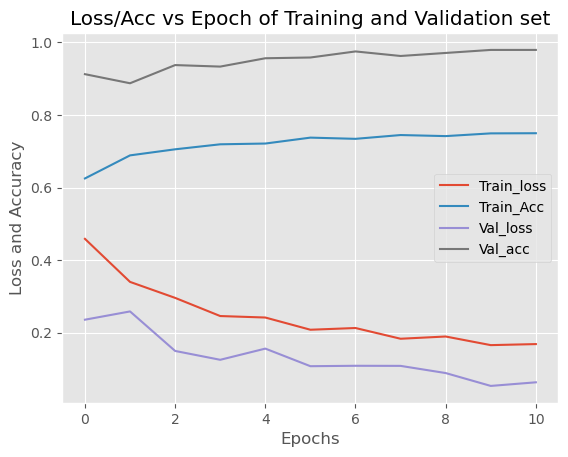

In [ ]:
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
plt.title("Loss/Acc vs Epoch of Training and Validation set")

plt.plot(Train_Val_Hist["train_loss"],label="Train_loss")
plt.plot(Train_Val_Hist["train_acc"],label="Train_Acc")
plt.plot(Train_Val_Hist["val_loss"],label="Val_loss")
plt.plot(Train_Val_Hist["val_acc"],label="Val_acc")

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.legend(loc="best")

plt.show()


In [ ]:
if args['model']=='vgg':
    torch.save(model.state_dict(), VGG_Model_path)
elif args['model']=='resnet':
    torch.save(model.state_dict(), RESNET_Model_path)    
elif args['model']=='mobilenet':
    torch.save(model.state_dict(), MobileNet_Model_path )   

In [ ]:
gc.collect()
torch.cuda.empty_cache()